In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #Used to load the OCTAVE *.mat files
import scipy.optimize #Use for fmincg

In [8]:
datafile = 'data/ex8_movies.mat'
mat = scipy.io.loadmat( datafile )
Y = mat['Y']
R = mat['R']

nm, nu = Y.shape


#Y : ratings (1-5) of 1682 movies on 943 users (1682, 943)
# R(i,j)  : 1 if user j gave a rating to movie i

In [9]:
nm, nu = Y.shape

In [10]:
Y.shape

(1682, 943)

In [11]:
R.shape

(1682, 943)

In [12]:
#R[9] #baris ke 9
#R[:,2] #kolom ke 2

for i in np.arange(1682):
    for x in np.arange(943):
            if (Y[i,x] == 0)&(R[i,x] == 1):
                print(i,x)
                
#karena  gada yg di print berarti y=0 artinya movie wasn't rated

Average rating for movie 1: 3.8783185840707963


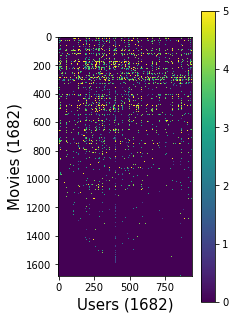

In [13]:
meanM1 = np.mean([Y[0][x] for x in np.arange(Y.shape[1]) if R[0][x] ]) 
#if TRUE: movie have rated. just measuring movie that have rated
print ("Average rating for movie 1:", meanM1)

#Visualize the rating matrix
plt.figure(figsize=(3,3*(1682./943.)))
plt.imshow(Y)
plt.colorbar()
plt.ylabel('Movies (%d)'%nm,fontsize=15)
plt.xlabel('Users (%d)'%nm,fontsize=15)
plt.show()

# Collaborative Filtering

In [14]:
datafile = 'data/ex8_movieParams.mat'
mat = scipy.io.loadmat(datafile)
X = mat['X']
theta = mat['Theta']
nu = int(mat['num_users'])
nm = int(mat['num_movies'])
nf = int(mat['num_features'])

In [15]:
#FOR NOW, reduce the dataset size so that this run faster
nu=4; nm=5; nf=3
X = X[:nm, :nf]
theta = theta[:nu, :nf]  #user,feature X
Y = Y[:nm, :nu]
R = R[:nm, :nu]

In [16]:
def flattenParams(myX, myTheta):
    con = np.concatenate((myX.flatten(), myTheta.flatten()))
    return(con)

def reshapeParams(flattenedXTheta, nm, nu, nf):
    reshapeX = flattenedXTheta[:int(nm*nf)].reshape((nm,nf))
    reshapeTheta = flattenedXTheta[int(nm*nf):].reshape((nu,nf))
    
    return (reshapeX,reshapeTheta)

### 1. Collaborative filtering cost function + Regularized 

In [17]:
def cofiCostFunct(myparams, Y, R, nu, nm, nf, mylambda = 0.):
    X, theta = reshapeParams(myparams, nm, nu, nf)
    
    # Note: 
    # X Shape is (nm x nf), 
    # Theta shape is (nu x nf), 
    # Y and R shape is (nm x nu)
    # Behold! Complete vectorization
    
    # First dot theta and X together such that you get a matrix 
    #the same shape as Y
    term1 = X.dot(theta.T) #result: Rating of movies from users
    #term1 = include data yg belum di rated, karna kita initial X(feature)
    #semua tanpa terkecuali
    #term2 = kita filter dengan matrix R. movies yg belum di rate akan jadi 0
    term2 = np.multiply(term1,R)
    
    cost = (1/2)*np.sum(np.square(term2-Y))
    
    #REG
    cost += (mylambda/2.)*np.sum(np.square(theta))
    cost += (mylambda/2.)*np.sum(np.square(X))
    
    return cost

#### costFunction, 
using theta & X initialize randomly (belum di gradient/cari optimal)

In [18]:
wolambda = cofiCostFunct(flattenParams(X,theta),Y,R,nu,nm,nf)
print('Cost with lambda:0 = ',wolambda)
wlambda = cofiCostFunct(flattenParams(X,theta),Y,R,nu,nm,nf,mylambda=1.5)
print('Cost with lambda:1.5 =',wlambda)

Cost with lambda:0 =  22.224603725685675
Cost with lambda:1.5 = 31.34405624427422


### 2.Collaborative filtering GradientDescent

In [26]:
def cofiGrad(myparams,Y,R,nu,nm,nf,mylambda=0.):
    X,theta = reshapeParams(myparams,nm,nu,nf)
    
    term1 = X.dot(theta.T)
    term1 = np.multiply(term1,R)
    term1 -= Y
    
    Xgrad = term1.dot(theta)
    thetaGrad = term1.T.dot(X)
    
    #REG
    Xgrad += mylambda * X
    thetaGrad += mylambda *theta
    
    #nilai gradient nya (turunan, belum dikali lerning rate)
    return(flattenParams(Xgrad,thetaGrad))

In [32]:
#Let's check my gradient computation real quick:
def checkGradient(myparams, myY, myR, mynu, mynm, mynf, mylambda = 0.):
    
    print ('Numerical Gradient \t cofiGrad \t\t Difference')
    
    # Compute a numerical gradient with an epsilon perturbation vector
    myeps = 0.0001
    nparams = len(myparams)
    epsvec = np.zeros(nparams)
    # These are my implemented gradient solutions
    mygrads = cofiGrad(myparams,myY,myR,mynu,mynm,mynf,mylambda)

    # Choose 10 random elements of my combined (X, Theta) param vector
    # and compute the numerical gradient for each... print to screen
    # the numerical gradient next to the my cofiGradient to inspect
    
    for i in np.arange(10):
        idx = np.random.randint(0,nparams)
        epsvec[idx] = myeps
        #loss1 = param- epsilon
        loss1 = cofiCostFunct(myparams-epsvec,myY,myR,mynu,mynm,mynf,mylambda)
        #loss2 = param+epsilon
        loss2 = cofiCostFunct(myparams+epsvec,myY,myR,mynu,mynm,mynf,mylambda)
        
        
        mygrad = (loss2 - loss1) / (2*myeps)
        epsvec[idx] = 0
        print (mygrad,mygrads[idx],mygrad- mygrads[idx])

In [33]:
print ("Checking gradient with lambda = 0....")
checkGradient(flattenParams(X,theta),Y,R,nu,nm,nf)
print( "\n \n Checking gradient with lambda = 1.5..... ")
checkGradient(flattenParams(X,theta),Y,R,nu,nm,nf,mylambda = 1.5)

Checking gradient with lambda = 0....
Numerical Gradient 	 cofiGrad 		 Difference
0.0 0.0 0.0
0.0 0.0 0.0
-0.8324071330889637 -0.832407133096985 8.021250330614293e-12
-0.8324071330889637 -0.832407133096985 8.021250330614293e-12
4.62776019000799 4.627760190006159 1.8314239014216582e-12
1.1644136694499707 1.1644136694462246 3.746114529690203e-12
0.0 0.0 0.0
-0.7667787767040579 -0.7667787767036732 -3.8469227803261674e-13
-0.7667787767040579 -0.7667787767036732 -3.8469227803261674e-13
-7.160044429745938 -7.160044429740946 -4.991562718714704e-12

 
 Checking gradient with lambda = 1.5..... 
Numerical Gradient 	 cofiGrad 		 Difference
0.4824409778692029 0.4824409778790828 -9.879874696139268e-12
-6.765636277386022 -6.765636277366185 -1.9837465004002297e-11
-0.40784085793887925 -0.40784085793527913 -3.600120201951995e-12
2.774211446130437 2.7742114461243377 6.09912120808076e-12
2.1013625613619524 2.1013625613886817 -2.672928545166542e-11
-0.8924733436010968 -0.8924733435974324 -3.6644021150777

# Learning movie recommendations

### 1. Recommendations

In [34]:
# So, this file has the list of movies and their respective index in the Y vector
# Let's make a list of strings to reference later
movies = []
with open('data/movie_ids.txt', encoding = "ISO-8859-1") as f:
    for line in f:
        movies.append(' '.join(line.strip('\n').split(' ')[1:]))

# Rather than rate some movies myself, I'll use what was built-in to the homework
# (just so I can check my solutions)


my_ratings = np.zeros((1682,1))
my_ratings[0]   = 4
my_ratings[97]  = 2
my_ratings[6]   = 3
my_ratings[11]  = 5
my_ratings[53]  = 4
my_ratings[63]  = 5
my_ratings[65]  = 3
my_ratings[68]  = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

In [35]:
# I'll re-read in the data because I shortened them earlier (to debug)
datafile = 'data/ex8_movies.mat'
mat = scipy.io.loadmat( datafile )
Y = mat['Y']
R = mat['R']
# We'll use 10 features
nf = 10

In [36]:
# Add my ratings to the Y matrix, and the relevant row to the R matrix
myR_row = my_ratings > 0
Y = np.hstack((Y,my_ratings))
R = np.hstack((R,myR_row))
nm, nu = Y.shape